### Predicting Boston Housing Prices

## Using XGBoost in SageMaker (Hyperparameter Tuning, _high-level_)

_Deep Learning Nanodegree Program | Deployment_

---

As an introduction to using SageMaker's High Level Python API for **hyperparameter tuning**, we will look again at the [Boston Housing Dataset](https://www.cs.toronto.edu/~delve/data/boston/bostonDetail.html) project from before. 

## General Outline

The same steps 1 to 5 are performed but with hyperparameter tuning in step 4 using the _high-level approach_: 

1. Download or otherwise retrieve the data.
2. Process / Prepare the data.
3. Upload the processed data to S3.
4. Train a chosen model **with hyperparameter tuning**
5. Test the trained model (typically using a batch transform job).


### On Hyperparameter tuning

Generally speaking, the way to think about hyperparameter tuning inside of SageMaker is that 
1. We start with a base collection of hyperparameters which describe a default model. 
2. We then give some additional set of hyperparameters ranges. These ranges tell SageMaker which hyperparameters can be varied, with the goal being to improve the default model.
3. We then describe a) how to compare models, which in our instance is just by way of specifying a metric. Then we describe b) how many total models we want SageMaker to train.

**Note**: In addition to creating a tuned model in this notebook, we also see how the attach method can be used to create an Estimator object which is attached to an already completed training job. This method is useful in other situations as well. (For example if we run different notebooks with the same model, we could use the attach method to avoid having ot re-train the model every time.) 

## Step 0: Setting up the notebook

In [1]:
import os
import numpy as np
import pandas as pd

import matplotlib.pyplot as plt
%matplotlib inline

from sklearn.datasets import load_boston
import sklearn.model_selection

In [2]:
import sagemaker
from sagemaker import get_execution_role
from sagemaker.amazon.amazon_estimator import get_image_uri
from sagemaker.predictor import csv_serializer

# This is an object that represents the SageMaker session that we are currently operating in. This
# object contains some useful information that we will need to access later such as our region.
session = sagemaker.Session()

# This is an object that represents the IAM role that we are currently assigned. When we construct
# and launch the training job later we will need to tell it what IAM role it should have. Since our
# use case is relatively simple we will simply assign the training job the role we currently have.
role = get_execution_role()

## Step 1: Downloading the data

In [3]:
boston = load_boston()

## Step 2: Preparing and splitting the data

In [4]:
# First we package up the input data and the target variable (the median value) as pandas dataframes. This
# will make saving the data to a file a little easier later on.

X_bos_pd = pd.DataFrame(boston.data, columns=boston.feature_names)
Y_bos_pd = pd.DataFrame(boston.target)

# We split the dataset into 2/3 training and 1/3 testing sets.
X_train, X_test, Y_train, Y_test = sklearn.model_selection.train_test_split(X_bos_pd, Y_bos_pd, test_size=0.33)

# Then we split the training set further into 2/3 training and 1/3 validation sets.
X_train, X_val, Y_train, Y_val = sklearn.model_selection.train_test_split(X_train, Y_train, test_size=0.33)

## Step 3: Uploading the data files to S3

In [5]:
# This is our local data directory. We need to make sure that it exists.
data_dir = '../data/boston'
if not os.path.exists(data_dir):
    os.makedirs(data_dir)

In [6]:
# We use pandas to save our test, train and validation data to csv files. Note that we make sure not to include header
# information or an index as this is required by the built in algorithms provided by Amazon. Also, for the train and
# validation data, it is assumed that the first entry in each row is the target variable.

X_test.to_csv(os.path.join(data_dir, 'test.csv'), header=False, index=False)

pd.concat([Y_val, X_val], axis=1).to_csv(os.path.join(data_dir, 'validation.csv'), header=False, index=False)
pd.concat([Y_train, X_train], axis=1).to_csv(os.path.join(data_dir, 'train.csv'), header=False, index=False)

In [7]:
prefix = 'boston-xgboost-tuning-HL'

test_location = session.upload_data(os.path.join(data_dir, 'test.csv'), key_prefix=prefix)
val_location = session.upload_data(os.path.join(data_dir, 'validation.csv'), key_prefix=prefix)
train_location = session.upload_data(os.path.join(data_dir, 'train.csv'), key_prefix=prefix)

## Step 4: Train the XGBoost model

In [9]:
# As stated above, we use this utility method to construct the image name for the training container.
container = get_image_uri(session.boto_region_name, 'xgboost', '0.90-1')

# Now that we know which container to use, we can construct the estimator object.
xgb = sagemaker.estimator.Estimator(container, # The name of the training container
                                    role,      # The IAM role to use (our current role in this case)
                                    train_instance_count=1, # The number of instances to use for training
                                    train_instance_type='ml.m4.xlarge', # The type of instance ot use for training
                                    output_path='s3://{}/{}/output'.format(session.default_bucket(), prefix),
                                                                        # Where to save the output (the model artifacts)
                                    sagemaker_session=session) # The current SageMaker session

**Set default values**

Before beginning the hyperparameter tuning, we should make sure to set any model specific hyperparameters that we wish to have default values.

In [10]:
xgb.set_hyperparameters(max_depth=5,
                        eta=0.2,
                        gamma=4,
                        min_child_weight=6,
                        subsample=0.8,
                        objective='reg:linear',
                        early_stopping_rounds=10,
                        num_round=200)

**Create the hyperparameter tuner**. 

To do this we need to construct a new object which contains each of the parameters we want SageMaker to tune. In this case, we wish to find the best values for the `max_depth`, `eta`, `min_child_weight`, `subsample`, and `gamma` parameters. Note that for each parameter that we want SageMaker to tune we need to specify both the *type* of the parameter and the *range* of values that parameter may take on.

In addition, we specify the *number* of models to construct (`max_jobs`) and the number of those that can be trained in parallel (`max_parallel_jobs`). In the cell below we have chosen to train `20` models, of which we ask that SageMaker train `3` at a time in parallel. (Note that this results in a total of `20` training jobs being executed which can take some time, in this case almost a half hour. With more complicated models this can take even longer so be aware!)

In [11]:
from sagemaker.tuner import IntegerParameter, ContinuousParameter, HyperparameterTuner

xgb_hyperparameter_tuner = HyperparameterTuner(estimator = xgb, # Estimator object to use as the basis for the training jobs.
                                               objective_metric_name = 'validation:rmse', # Metric used to compare on val data.
                                               objective_type = 'Minimize', # Whether to minimize or maximize the metric.
                                               max_jobs = 20, # Total number of models to train
                                               max_parallel_jobs = 3, # Number of models to train in parallel
                                               hyperparameter_ranges = {
                                                    'max_depth': IntegerParameter(3, 12),
                                                    'eta'      : ContinuousParameter(0.05, 0.5),
                                                    'min_child_weight': IntegerParameter(2, 8),
                                                    'subsample': ContinuousParameter(0.5, 0.9),
                                                    'gamma': ContinuousParameter(0, 10),
                                               })

**Train models**

To do this we make sure that SageMaker knows our input data is in csv format and then execute the `fit` method.

In [12]:
s3_input_train = sagemaker.s3_input(s3_data=train_location, content_type='csv')
s3_input_validation = sagemaker.s3_input(s3_data=val_location, content_type='csv')

xgb_hyperparameter_tuner.fit({'train': s3_input_train, 'validation': s3_input_validation})

As in many of the examples we have seen so far, the `fit()` method takes care of setting up and fitting a number of different models, each with different hyperparameters. If we wish to wait for this process to finish, we can call the `wait()` method.

In [13]:
xgb_hyperparameter_tuner.wait()

............................................................................................................................................................................................................................................................................................!


**Check for best model**

Once the hyperamater tuner has finished, we can retrieve information about the best performing model. 

In [14]:
xgb_hyperparameter_tuner.best_training_job()

'sagemaker-xgboost-191225-1219-014-0ac3cce9'

**Create new estimator object**

In addition, since we'd like to set up a batch transform job to test the best model, we can construct a new estimator object from the results of the best training job. The `xgb_attached` object below can now be used as though we constructed an estimator with the best performing hyperparameters and then fit it to our training data.

In [15]:
xgb_attached = sagemaker.estimator.Estimator.attach(xgb_hyperparameter_tuner.best_training_job())

2019-12-25 12:35:54 Starting - Preparing the instances for training
2019-12-25 12:35:54 Downloading - Downloading input data
2019-12-25 12:35:54 Training - Training image download completed. Training in progress.
2019-12-25 12:35:54 Uploading - Uploading generated training model
2019-12-25 12:35:54 Completed - Training job completedINFO:sagemaker-containers:Imported framework sagemaker_xgboost_container.training
INFO:sagemaker-containers:Failed to parse hyperparameter _tuning_objective_metric value validation:rmse to Json.
Returning the value itself
INFO:sagemaker-containers:Failed to parse hyperparameter objective value reg:linear to Json.
Returning the value itself
INFO:sagemaker-containers:No GPUs detected (normal if no gpus installed)
INFO:sagemaker_xgboost_container.training:Running XGBoost Sagemaker in algorithm mode
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
INFO:root:Determined delimiter of CSV input is ','
[12:35:44] 2

## Step 5: Test the model

In [16]:
xgb_transformer = xgb_attached.transformer(instance_count = 1, instance_type = 'ml.m4.xlarge')

In [17]:
xgb_transformer.transform(test_location, content_type='text/csv', split_type='Line')

In [18]:
xgb_transformer.wait()

.....................
.[2019-12-25 12:46:55 +0000] [14] [INFO] Starting gunicorn 19.10.0
[2019-12-25 12:46:55 +0000] [14] [INFO] Listening at: unix:/tmp/gunicorn.sock (14)
[2019-12-25 12:46:55 +0000] [14] [INFO] Using worker: gevent
[2019-12-25 12:46:55 +0000] [21] [INFO] Booting worker with pid: 21
[2019-12-25 12:46:55 +0000] [25] [INFO] Booting worker with pid: 25
[2019-12-25 12:46:55 +0000] [26] [INFO] Booting worker with pid: 26
[2019-12-25 12:46:55 +0000] [27] [INFO] Booting worker with pid: 27
[2019-12-25 12:46:55 +0000] [14] [INFO] Starting gunicorn 19.10.0
[2019-12-25 12:46:55 +0000] [14] [INFO] Listening at: unix:/tmp/gunicorn.sock (14)
[2019-12-25 12:46:55 +0000] [14] [INFO] Using worker: gevent
[2019-12-25 12:46:55 +0000] [21] [INFO] Booting worker with pid: 21
[2019-12-25 12:46:55 +0000] [25] [INFO] Booting worker with pid: 25
[2019-12-25 12:46:55 +0000] [26] [INFO] Booting worker with pid: 26
[2019-12-25 12:46:55 +0000] [27] [INFO] Booting worker with pid: 27
[2019-12-25:1

In [19]:
!aws s3 cp --recursive $xgb_transformer.output_path $data_dir

download: s3://sagemaker-eu-west-1-873674308518/sagemaker-xgboost-191225-1219-014-0ac3c-2019-12-25-12-43-31-424/test.csv.out to ../data/boston/test.csv.out


In [20]:
Y_pred = pd.read_csv(os.path.join(data_dir, 'test.csv.out'), header=None)

Text(0.5, 1.0, 'Median Price vs Predicted Price')

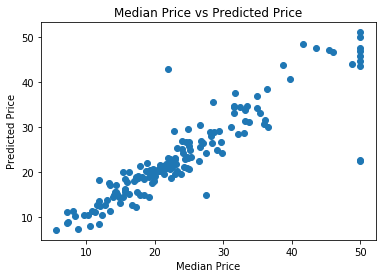

In [21]:
plt.scatter(Y_test, Y_pred)
plt.xlabel("Median Price")
plt.ylabel("Predicted Price")
plt.title("Median Price vs Predicted Price")

## Optional: Clean up

In [22]:
!rm $data_dir/*
!rmdir $data_dir

---